# Modeling: LightGBM Regressor

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from feature_engine.creation import CyclicalFeatures
from feature_engine.transformation import LogCpTransformer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (LagFeatures, WindowFeatures)
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             mean_absolute_error, 
                             mean_absolute_percentage_error
                            )
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import lightgbm as lgbm


In [2]:
data = pd.read_csv('../data/processed/reservoir_cleaned_data.csv', parse_dates=["timestamp"])
data.head()

,timestamp,generation_cleaned
0,2014-12-31 23:00:00+00:00,1899.0
1,2015-01-01 00:00:00+00:00,1658.0
2,2015-01-01 01:00:00+00:00,1371.0
3,2015-01-01 02:00:00+00:00,779.0
4,2015-01-01 03:00:00+00:00,720.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           35064 non-null  datetime64[ns, UTC]
 1   generation_cleaned  35064 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 548.0 KB


In [4]:
# Timestamp column transformation
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True).dt.tz_convert('Europe/Madrid')        

In [5]:
# Generation reservoir water
reservoir_gen = data.set_index('timestamp') \
                    .asfreq('H') \
                    .interpolate() \
                    .sort_index()
reservoir_gen

,generation_cleaned
timestamp,
2015-01-01 00:00:00+01:00,1899.0
2015-01-01 01:00:00+01:00,1658.0
2015-01-01 02:00:00+01:00,1371.0
2015-01-01 03:00:00+01:00,779.0
2015-01-01 04:00:00+01:00,720.0
...,...
2018-12-31 19:00:00+01:00,4836.0
2018-12-31 20:00:00+01:00,3931.0
2018-12-31 21:00:00+01:00,2831.0


In [6]:
def remove_outliers(df, value_col, period = None, robust = True):
    serie = df[value_col]
    res = STL(serie, period = period, robust = robust).fit()
    resid = res.resid
    q1 = resid.quantile(0.25)
    q3 = resid.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - (3*iqr)
    upper = q3 + (3*iqr)
    
    anomalies = serie[(resid < lower) | (resid >= upper)]
    df = df.assign(anomaly = np.where(df[value_col].index.isin(anomalies.index), True, False))
    df["value_corrected"] = np.where(df["anomaly"] == True, np.NaN, df[value_col])
    df.interpolate(method = "linear", inplace=True)
    df["value_corrected"] = np.where(df["value_corrected"].isna(), df[value_col], df["value_corrected"])
    return df

In [7]:
data_sin_outliers = remove_outliers(reservoir_gen, 'generation_cleaned')
data_sin_outliers = data_sin_outliers.drop(['generation_cleaned', 'anomaly'], axis = 1)

<Axes: xlabel='timestamp'>

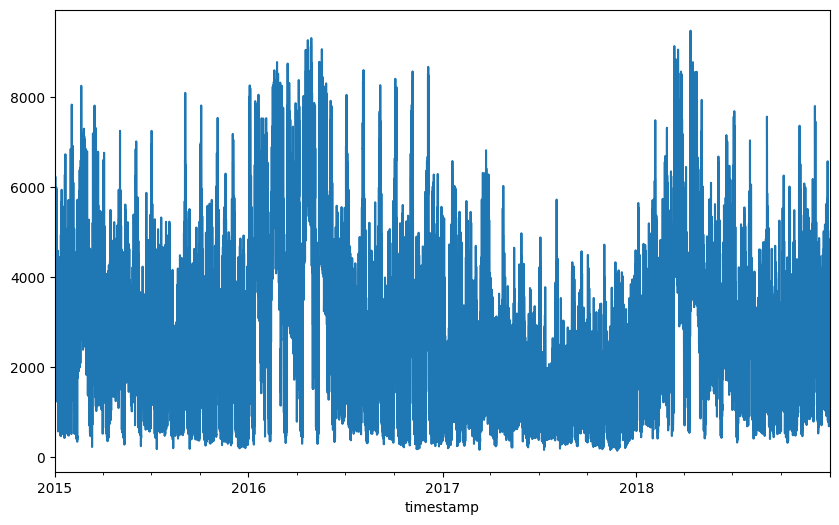

In [8]:
data_sin_outliers['value_corrected'].plot(figsize=(10,6))

In [9]:
# Validation split
val_len = 24
in_sample_df = data_sin_outliers.iloc[:-val_len, :]
out_of_sample_df = data_sin_outliers.iloc[-val_len:, :]

In [10]:
in_sample_df = in_sample_df.reset_index()
out_of_sample_df = out_of_sample_df.reset_index()

In [11]:
# Train test split
test_time = pd.Timedelta(24*7, unit='H')
split_point = in_sample_df['timestamp'].max() - test_time

X_train = in_sample_df[in_sample_df['timestamp'] < split_point]
X_test = in_sample_df[in_sample_df['timestamp'] >= split_point - pd.Timedelta(24*4, unit = 'H')]

y_train = in_sample_df[in_sample_df['timestamp'] < split_point][['timestamp', 'value_corrected']]
y_test = in_sample_df[in_sample_df['timestamp'] >= split_point - pd.Timedelta(24*4, unit='H')][['timestamp', 'value_corrected']]

In [12]:
X_train = X_train.set_index('timestamp')
X_test = X_test.set_index('timestamp')
y_train = y_train.set_index('timestamp')
y_test = y_test.set_index('timestamp')

## Feature Engineering

In [13]:
# Fourier Features Class
class AddFourierFeatures(BaseEstimator, TransformerMixin):
    seconds_per_day = 24*60*60     # Daily dataset
    seconds_per_hour = 60*60       # Hourly dataset

    def __init__(self, K, periods: list, by = "day"):
        self.K = K
        self.periods = periods
        self.by = by

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):
        X = X.copy()
        dates = X.index
        
        for period in self.periods:
            term = self.K / period
            timestamps = dates.map(datetime.datetime.timestamp)
            ts_scaled = []

            for ts in timestamps:
                if self.by == "day":
                    x_scaled = round(ts / self.seconds_per_day)
                    ts_scaled.append(x_scaled)
                else:
                    x_scaled = round(ts / self.seconds_per_hour)
                    ts_scaled.append(x_scaled)

            X["fourier_sin"] = [np.sin(2 * np.pi * term * ts) for ts in ts_scaled]
            X["fourier_cos"] = [np.cos(2 * np.pi * term * ts) for ts in ts_scaled]

        return X

In [14]:
# Transformers
horizon = 24

dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "hour",
        "day_of_month",
        "month",
        "year",
        "day_of_year",
        "week",
        "day_of_week",
        "weekend"
    ],
    drop_original = False,
    utc = True
)

cyclicf = CyclicalFeatures(
    variables=["hour", "month", "day_of_year"],
    drop_original= True
)

fourierf = AddFourierFeatures(
    K = 1,
    periods=[horizon, horizon*2],
    by = "hour"
)

lagf = LagFeatures(
    variables="value_corrected",
    periods=list(range(1,horizon+1)),
    missing_values = "ignore"
)

windf24 = WindowFeatures(
    variables="value_corrected",
    functions=["mean"],
    window=[horizon],
    freq="1H",
    missing_values="ignore"
)

imputer = DropMissingData()

drop_features = DropFeatures(features_to_drop=["value_corrected"])

In [15]:
prep_pipeline = Pipeline([
    ('datetime features', dtf),
    ('cyclic features', cyclicf),
    ("fourier features", fourierf),
    ('lag features', lagf),
    ('window features', windf24),
    ('imputer', imputer),
    ('drop features', drop_features)
])

X_train_prep = prep_pipeline.fit_transform(X_train)
X_test_prep = prep_pipeline.transform(X_test)

In [16]:
# Align

y_train_t = y_train.loc[X_train_prep.index]
y_test_t = y_test.loc[X_test_prep.index]

In [17]:
dtrain = lgb.Dataset(X_train_prep, y_train_t)
dtest = lgb.Dataset(X_test_prep, y_test_t)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

params = {
    "objective":"regression",
    "metric": "rmse",
    "verbosity":-1,
    "boosting_type":"gbdt",
    "seed":42
}

tuner = lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds = cv,
    callbacks=[early_stopping(200), log_evaluation(100)]
)

tuner.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
[100]	cv_agg's rmse: 374.166 + 3.96439
[200]	cv_agg's rmse: 369.005 + 3.79049
[300]	cv_agg's rmse: 367.601 + 3.77845
[400]	cv_agg's rmse: 367.002 + 4.00726
[500]	cv_agg's rmse: 366.871 + 4.01172
[600]	cv_agg's rmse: 367.34 + 4.21204


feature_fraction, val_score: 366.793710:  14%|#4        | 1/7 [00:08<00:49,  8.21s/it]

Early stopping, best iteration is:
[467]	cv_agg's rmse: 366.794 + 4.05611
[100]	cv_agg's rmse: 373.862 + 3.47943
[200]	cv_agg's rmse: 368.935 + 3.56429
[300]	cv_agg's rmse: 367.229 + 4.17935
[400]	cv_agg's rmse: 366.706 + 4.52051
[500]	cv_agg's rmse: 366.503 + 4.46212
[600]	cv_agg's rmse: 366.579 + 4.76959
[700]	cv_agg's rmse: 366.839 + 4.71413


feature_fraction, val_score: 366.430109:  29%|##8       | 2/7 [00:16<00:41,  8.39s/it]

Early stopping, best iteration is:
[579]	cv_agg's rmse: 366.43 + 4.74892
[100]	cv_agg's rmse: 383.494 + 2.98857
[200]	cv_agg's rmse: 374.384 + 2.44277
[300]	cv_agg's rmse: 371.486 + 2.75155
[400]	cv_agg's rmse: 370.238 + 2.80925
[500]	cv_agg's rmse: 369.658 + 2.89533
[600]	cv_agg's rmse: 369.56 + 2.79396
[700]	cv_agg's rmse: 369.709 + 2.60447


feature_fraction, val_score: 366.430109:  43%|####2     | 3/7 [00:23<00:30,  7.69s/it]

Early stopping, best iteration is:
[579]	cv_agg's rmse: 366.43 + 4.74892
[100]	cv_agg's rmse: 377.377 + 3.04235
[200]	cv_agg's rmse: 370.916 + 2.78152
[300]	cv_agg's rmse: 368.636 + 2.63085
[400]	cv_agg's rmse: 367.866 + 2.47596
[500]	cv_agg's rmse: 367.571 + 2.57508
[600]	cv_agg's rmse: 367.574 + 2.81051
[700]	cv_agg's rmse: 367.742 + 3.00145


feature_fraction, val_score: 366.430109:  57%|#####7    | 4/7 [00:31<00:23,  7.97s/it]

Early stopping, best iteration is:
[579]	cv_agg's rmse: 366.43 + 4.74892
[100]	cv_agg's rmse: 381.587 + 2.6014
[200]	cv_agg's rmse: 373.761 + 3.05469
[300]	cv_agg's rmse: 370.661 + 3.08559
[400]	cv_agg's rmse: 369.856 + 3.0961
[500]	cv_agg's rmse: 369.792 + 3.15944
[600]	cv_agg's rmse: 369.64 + 3.18477
[700]	cv_agg's rmse: 369.74 + 3.15875


feature_fraction, val_score: 366.430109:  71%|#######1  | 5/7 [00:39<00:15,  7.66s/it]

Early stopping, best iteration is:
[579]	cv_agg's rmse: 366.43 + 4.74892
[100]	cv_agg's rmse: 372.998 + 4.09425
[200]	cv_agg's rmse: 367.979 + 3.48439
[300]	cv_agg's rmse: 366.685 + 3.44279
[400]	cv_agg's rmse: 366.3 + 3.46123
[500]	cv_agg's rmse: 366.37 + 3.38448
[600]	cv_agg's rmse: 366.456 + 3.37809


feature_fraction, val_score: 366.152361:  86%|########5 | 6/7 [00:46<00:07,  7.44s/it]

Early stopping, best iteration is:
[443]	cv_agg's rmse: 366.152 + 3.48736
[100]	cv_agg's rmse: 371.695 + 3.44798
[200]	cv_agg's rmse: 367.003 + 4.00296
[300]	cv_agg's rmse: 365.697 + 4.5293
[400]	cv_agg's rmse: 365.268 + 5.10639
[500]	cv_agg's rmse: 365.223 + 5.16678
[600]	cv_agg's rmse: 365.436 + 5.27505


feature_fraction, val_score: 365.131583: 100%|##########| 7/7 [00:55<00:00,  7.87s/it]


[700]	cv_agg's rmse: 365.886 + 5.54443
Early stopping, best iteration is:
[505]	cv_agg's rmse: 365.132 + 5.27501


num_leaves, val_score: 365.131583:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 370.913 + 2.97235
[200]	cv_agg's rmse: 372.128 + 2.45003
[300]	cv_agg's rmse: 372.93 + 2.44855
[400]	cv_agg's rmse: 373.312 + 2.52732
[500]	cv_agg's rmse: 373.512 + 2.54475
[600]	cv_agg's rmse: 373.658 + 2.56035
[700]	cv_agg's rmse: 373.743 + 2.54713


num_leaves, val_score: 365.131583:   5%|5         | 1/20 [00:39<12:33, 39.65s/it]

Early stopping, best iteration is:
[505]	cv_agg's rmse: 365.132 + 5.27501
[100]	cv_agg's rmse: 365.931 + 3.83688
[200]	cv_agg's rmse: 366.038 + 4.15907
[300]	cv_agg's rmse: 367 + 4.32966
[400]	cv_agg's rmse: 367.644 + 4.41057
[500]	cv_agg's rmse: 368.361 + 4.4061
[600]	cv_agg's rmse: 368.89 + 4.38776


num_leaves, val_score: 365.131583:  10%|#         | 2/20 [01:04<09:18, 31.03s/it]

[700]	cv_agg's rmse: 369.353 + 4.48142
Early stopping, best iteration is:
[505]	cv_agg's rmse: 365.132 + 5.27501
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 364.07 + 3.50249
[300]	cv_agg's rmse: 364.004 + 3.75907
[400]	cv_agg's rmse: 364.424 + 3.71988


num_leaves, val_score: 363.698961:  15%|#5        | 3/20 [01:20<06:51, 24.22s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 369.977 + 4.08475
[200]	cv_agg's rmse: 370.999 + 3.95109
[300]	cv_agg's rmse: 372.088 + 4.13037
[400]	cv_agg's rmse: 372.554 + 4.01155


num_leaves, val_score: 363.698961:  20%|##        | 4/20 [01:46<06:39, 24.96s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 365.177 + 4.03129
[200]	cv_agg's rmse: 364.641 + 3.919
[300]	cv_agg's rmse: 365.515 + 4.10889
[400]	cv_agg's rmse: 366.002 + 4.07867


num_leaves, val_score: 363.698961:  25%|##5       | 5/20 [01:57<04:58, 19.91s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.846 + 4.57832
[200]	cv_agg's rmse: 367.366 + 4.8873
[300]	cv_agg's rmse: 368.232 + 4.6909
[400]	cv_agg's rmse: 368.807 + 4.92421


num_leaves, val_score: 363.698961:  30%|###       | 6/20 [02:15<04:27, 19.10s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.679 + 3.41557
[200]	cv_agg's rmse: 367.571 + 3.46666
[300]	cv_agg's rmse: 368.587 + 3.82206
[400]	cv_agg's rmse: 369.483 + 3.91191


num_leaves, val_score: 363.698961:  35%|###5      | 7/20 [02:32<04:00, 18.52s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 367.009 + 3.02059
[200]	cv_agg's rmse: 367.407 + 3.42887
[300]	cv_agg's rmse: 368.084 + 3.48742
[400]	cv_agg's rmse: 368.656 + 3.51992


num_leaves, val_score: 363.698961:  40%|####      | 8/20 [02:48<03:31, 17.64s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.834 + 4.91076
[200]	cv_agg's rmse: 367.34 + 4.64843
[300]	cv_agg's rmse: 368.301 + 4.42911
[400]	cv_agg's rmse: 369.069 + 4.43176


num_leaves, val_score: 363.698961:  45%|####5     | 9/20 [03:02<03:03, 16.65s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 385.225 + 3.08232
[200]	cv_agg's rmse: 375.574 + 3.10263
[300]	cv_agg's rmse: 371.563 + 2.96012
[400]	cv_agg's rmse: 369.695 + 3.21834


num_leaves, val_score: 363.698961:  50%|#####     | 10/20 [03:06<02:06, 12.65s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 383.66 + 2.86979
[200]	cv_agg's rmse: 374.693 + 2.83482
[300]	cv_agg's rmse: 371.11 + 2.81628
[400]	cv_agg's rmse: 369.094 + 2.96775


num_leaves, val_score: 363.698961:  55%|#####5    | 11/20 [03:10<01:29,  9.99s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.42 + 3.53586
[200]	cv_agg's rmse: 365.377 + 3.56416
[300]	cv_agg's rmse: 365.351 + 4.04741
[400]	cv_agg's rmse: 365.922 + 4.17606


num_leaves, val_score: 363.698961:  60%|######    | 12/20 [03:19<01:18,  9.80s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.618 + 3.63452
[200]	cv_agg's rmse: 364.731 + 3.29075
[300]	cv_agg's rmse: 364.726 + 3.11287
[400]	cv_agg's rmse: 365.132 + 3.23195


num_leaves, val_score: 363.698961:  65%|######5   | 13/20 [03:28<01:05,  9.40s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 367.455 + 2.8437
[200]	cv_agg's rmse: 364.986 + 2.99715
[300]	cv_agg's rmse: 364.863 + 2.96393
[400]	cv_agg's rmse: 365.084 + 3.40008


num_leaves, val_score: 363.698961:  70%|#######   | 14/20 [03:36<00:53,  8.90s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 367.455 + 2.8437
[200]	cv_agg's rmse: 364.986 + 2.99715
[300]	cv_agg's rmse: 364.863 + 2.96393
[400]	cv_agg's rmse: 365.084 + 3.40008


num_leaves, val_score: 363.698961:  75%|#######5  | 15/20 [03:43<00:42,  8.53s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.989 + 2.91973
[200]	cv_agg's rmse: 365.373 + 2.84249
[300]	cv_agg's rmse: 364.536 + 3.11496
[400]	cv_agg's rmse: 364.372 + 3.44779


num_leaves, val_score: 363.698961:  80%|########  | 16/20 [03:51<00:33,  8.31s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.921 + 4.18263
[200]	cv_agg's rmse: 370.315 + 4.16888
[300]	cv_agg's rmse: 371.598 + 4.51653
[400]	cv_agg's rmse: 372.373 + 4.60483


num_leaves, val_score: 363.698961:  85%|########5 | 17/20 [04:11<00:35, 11.86s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 365.177 + 4.03129
[200]	cv_agg's rmse: 364.641 + 3.919
[300]	cv_agg's rmse: 365.515 + 4.10889
[400]	cv_agg's rmse: 366.002 + 4.07867


num_leaves, val_score: 363.698961:  90%|######### | 18/20 [04:21<00:22, 11.24s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 367.606 + 4.31696
[200]	cv_agg's rmse: 368.717 + 4.15092
[300]	cv_agg's rmse: 369.599 + 4.37765
[400]	cv_agg's rmse: 370.229 + 4.4043


num_leaves, val_score: 363.698961:  95%|#########5| 19/20 [04:40<00:13, 13.53s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 370.099 + 2.88534
[200]	cv_agg's rmse: 366.136 + 2.45568
[300]	cv_agg's rmse: 365.273 + 2.42197
[400]	cv_agg's rmse: 364.834 + 2.81107


num_leaves, val_score: 363.698961: 100%|##########| 20/20 [04:46<00:00, 14.33s/it]


Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037


bagging, val_score: 363.698961:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 372.867 + 3.17483
[200]	cv_agg's rmse: 372.748 + 3.45291
[300]	cv_agg's rmse: 374.69 + 3.96747
[400]	cv_agg's rmse: 376.251 + 3.70831


bagging, val_score: 363.698961:  10%|#         | 1/10 [00:14<02:07, 14.16s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 372.28 + 4.49087
[200]	cv_agg's rmse: 372.546 + 4.31166
[300]	cv_agg's rmse: 374.172 + 4.36726
[400]	cv_agg's rmse: 375.896 + 4.71645


bagging, val_score: 363.698961:  20%|##        | 2/10 [00:26<01:43, 12.89s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.47 + 4.10738
[200]	cv_agg's rmse: 367.194 + 3.47189
[300]	cv_agg's rmse: 367.941 + 3.24805
[400]	cv_agg's rmse: 368.746 + 3.7042


bagging, val_score: 363.698961:  30%|###       | 3/10 [00:35<01:18, 11.19s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.676 + 3.11405
[200]	cv_agg's rmse: 368.046 + 2.91267
[300]	cv_agg's rmse: 368.805 + 2.96896
[400]	cv_agg's rmse: 370.061 + 3.22437


bagging, val_score: 363.698961:  40%|####      | 4/10 [00:46<01:07, 11.30s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.122 + 3.86785
[200]	cv_agg's rmse: 366.587 + 3.78737
[300]	cv_agg's rmse: 367.017 + 3.75832
[400]	cv_agg's rmse: 367.627 + 3.89435


bagging, val_score: 363.698961:  50%|#####     | 5/10 [00:56<00:52, 10.57s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 370.331 + 3.5355
[200]	cv_agg's rmse: 370.213 + 3.73206
[300]	cv_agg's rmse: 371.281 + 3.97228
[400]	cv_agg's rmse: 372.757 + 3.83168


bagging, val_score: 363.698961:  60%|######    | 6/10 [01:06<00:42, 10.61s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 369.56 + 3.50403
[200]	cv_agg's rmse: 368.892 + 3.68457
[300]	cv_agg's rmse: 369.029 + 4.02894
[400]	cv_agg's rmse: 369.734 + 4.24812


bagging, val_score: 363.698961:  70%|#######   | 7/10 [01:15<00:30, 10.15s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.784 + 4.11031
[200]	cv_agg's rmse: 368.025 + 3.85324
[300]	cv_agg's rmse: 368.996 + 3.95077
[400]	cv_agg's rmse: 370.437 + 3.57347


bagging, val_score: 363.698961:  80%|########  | 8/10 [01:26<00:20, 10.35s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 369.011 + 2.90073
[200]	cv_agg's rmse: 368.943 + 3.12055
[300]	cv_agg's rmse: 370.071 + 3.30087
[400]	cv_agg's rmse: 370.755 + 3.4345


bagging, val_score: 363.698961:  90%|######### | 9/10 [01:35<00:09,  9.98s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.473 + 3.61811
[200]	cv_agg's rmse: 365.356 + 3.67859
[300]	cv_agg's rmse: 366.335 + 3.89727
[400]	cv_agg's rmse: 366.963 + 4.05447


bagging, val_score: 363.698961: 100%|##########| 10/10 [01:48<00:00, 10.85s/it]


Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037


feature_fraction_stage2, val_score: 363.698961:   0%|          | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 366.853 + 3.62884
[200]	cv_agg's rmse: 364.483 + 3.48549
[300]	cv_agg's rmse: 364.662 + 3.87704
[400]	cv_agg's rmse: 364.849 + 3.99098


feature_fraction_stage2, val_score: 363.698961:  33%|###3      | 1/3 [00:08<00:17,  8.59s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.687 + 2.77253
[200]	cv_agg's rmse: 366.243 + 3.24125
[300]	cv_agg's rmse: 366.393 + 3.56553
[400]	cv_agg's rmse: 366.904 + 3.56717


feature_fraction_stage2, val_score: 363.698961:  67%|######6   | 2/3 [00:16<00:08,  8.10s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 368.213 + 3.88032
[200]	cv_agg's rmse: 365.836 + 4.1131
[300]	cv_agg's rmse: 365.516 + 3.73689
[400]	cv_agg's rmse: 365.824 + 3.96536


feature_fraction_stage2, val_score: 363.698961: 100%|##########| 3/3 [00:24<00:00,  8.16s/it]


Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037


regularization_factors, val_score: 363.698961:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 366.986 + 3.91455
[200]	cv_agg's rmse: 365.275 + 4.03711
[300]	cv_agg's rmse: 365.459 + 4.45676
[400]	cv_agg's rmse: 365.987 + 4.37608


regularization_factors, val_score: 363.698961:   5%|5         | 1/20 [00:09<03:05,  9.76s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.234 + 3.57516
[200]	cv_agg's rmse: 364.193 + 3.64906
[300]	cv_agg's rmse: 364.267 + 3.67311
[400]	cv_agg's rmse: 364.784 + 3.83732


regularization_factors, val_score: 363.698961:  10%|#         | 2/20 [00:18<02:46,  9.28s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.459 + 3.3749
[200]	cv_agg's rmse: 364.599 + 3.79557
[300]	cv_agg's rmse: 364.825 + 3.67172
[400]	cv_agg's rmse: 365.479 + 3.8288


regularization_factors, val_score: 363.698961:  15%|#5        | 3/20 [00:29<02:52, 10.12s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.966 + 3.80972
[200]	cv_agg's rmse: 365.146 + 4.1541
[300]	cv_agg's rmse: 365.674 + 3.89383
[400]	cv_agg's rmse: 366.116 + 4.06629


regularization_factors, val_score: 363.698961:  20%|##        | 4/20 [00:49<03:40, 13.80s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.234 + 3.57516
[200]	cv_agg's rmse: 364.176 + 3.69161
[300]	cv_agg's rmse: 364.341 + 3.67314
[400]	cv_agg's rmse: 364.898 + 3.844


regularization_factors, val_score: 363.698961:  25%|##5       | 5/20 [01:10<04:08, 16.58s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.729 + 3.37574
[200]	cv_agg's rmse: 365.213 + 3.74054
[300]	cv_agg's rmse: 365.472 + 3.84704
[400]	cv_agg's rmse: 366.075 + 3.91028


regularization_factors, val_score: 363.698961:  30%|###       | 6/20 [01:29<04:02, 17.33s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.548 + 3.35294
[200]	cv_agg's rmse: 364.73 + 3.67362
[300]	cv_agg's rmse: 365.095 + 3.71453
[400]	cv_agg's rmse: 365.661 + 3.88266


regularization_factors, val_score: 363.698961:  35%|###5      | 7/20 [01:50<04:02, 18.66s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.155 + 3.68177
[200]	cv_agg's rmse: 364.599 + 3.66654
[300]	cv_agg's rmse: 364.448 + 4.23896
[400]	cv_agg's rmse: 364.906 + 4.17655


regularization_factors, val_score: 363.698961:  40%|####      | 8/20 [02:11<03:50, 19.17s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.575 + 3.15994
[200]	cv_agg's rmse: 364.795 + 3.15583
[300]	cv_agg's rmse: 364.468 + 3.27318
[400]	cv_agg's rmse: 364.761 + 3.22495


regularization_factors, val_score: 363.698961:  45%|####5     | 9/20 [02:28<03:25, 18.69s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.408 + 3.24126
[200]	cv_agg's rmse: 364.903 + 3.55255
[300]	cv_agg's rmse: 365.062 + 3.38887
[400]	cv_agg's rmse: 365.375 + 3.33575


regularization_factors, val_score: 363.698961:  50%|#####     | 10/20 [02:42<02:50, 17.03s/it]

Early stopping, best iteration is:
[240]	cv_agg's rmse: 363.699 + 3.5037
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19796
[300]	cv_agg's rmse: 363.899 + 3.70099
[400]	cv_agg's rmse: 364.373 + 3.82969


regularization_factors, val_score: 363.681789:  55%|#####5    | 11/20 [02:53<02:16, 15.20s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19796
[300]	cv_agg's rmse: 363.899 + 3.70099
[400]	cv_agg's rmse: 364.373 + 3.82969


regularization_factors, val_score: 363.681788:  60%|######    | 12/20 [03:03<01:49, 13.71s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19796
[300]	cv_agg's rmse: 363.899 + 3.70099
[400]	cv_agg's rmse: 364.373 + 3.82969


regularization_factors, val_score: 363.681788:  65%|######5   | 13/20 [03:15<01:32, 13.22s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19796
[300]	cv_agg's rmse: 363.899 + 3.70099
[400]	cv_agg's rmse: 364.373 + 3.82969


regularization_factors, val_score: 363.681788:  70%|#######   | 14/20 [03:29<01:21, 13.57s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19796
[300]	cv_agg's rmse: 363.899 + 3.70099
[400]	cv_agg's rmse: 364.373 + 3.82969


regularization_factors, val_score: 363.681788:  75%|#######5  | 15/20 [03:39<01:02, 12.42s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19797
[300]	cv_agg's rmse: 363.899 + 3.70099
[400]	cv_agg's rmse: 364.373 + 3.82969


regularization_factors, val_score: 363.681782:  80%|########  | 16/20 [04:12<01:14, 18.68s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 364.07 + 3.50249
[300]	cv_agg's rmse: 363.941 + 3.76911
[400]	cv_agg's rmse: 364.322 + 3.74687


regularization_factors, val_score: 363.681782:  85%|########5 | 17/20 [04:53<01:15, 25.26s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19797
[300]	cv_agg's rmse: 363.899 + 3.70099
[400]	cv_agg's rmse: 364.373 + 3.82969


regularization_factors, val_score: 363.681781:  90%|######### | 18/20 [05:26<00:55, 27.66s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.253 + 3.60716
[200]	cv_agg's rmse: 363.891 + 3.19797
[300]	cv_agg's rmse: 363.907 + 3.69073
[400]	cv_agg's rmse: 364.33 + 3.87853


regularization_factors, val_score: 363.681769:  95%|#########5| 19/20 [06:09<00:32, 32.24s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.705 + 3.73589
[200]	cv_agg's rmse: 364.474 + 3.67045
[300]	cv_agg's rmse: 364.324 + 3.76966
[400]	cv_agg's rmse: 364.67 + 3.84144


regularization_factors, val_score: 363.681769: 100%|##########| 20/20 [06:32<00:00, 19.62s/it]


Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755


min_data_in_leaf, val_score: 363.681769:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 367.463 + 3.73864
[200]	cv_agg's rmse: 365.67 + 3.69086
[300]	cv_agg's rmse: 365.466 + 3.83809
[400]	cv_agg's rmse: 365.785 + 3.92118


min_data_in_leaf, val_score: 363.681769:  20%|##        | 1/5 [00:22<01:29, 22.50s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 367.731 + 3.10514
[200]	cv_agg's rmse: 366.051 + 3.16869
[300]	cv_agg's rmse: 365.893 + 2.76739
[400]	cv_agg's rmse: 366.193 + 2.9995


min_data_in_leaf, val_score: 363.681769:  40%|####      | 2/5 [00:44<01:06, 22.05s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 365.451 + 3.38808
[200]	cv_agg's rmse: 364.069 + 3.23347
[300]	cv_agg's rmse: 364.433 + 3.73507
[400]	cv_agg's rmse: 365.313 + 4.06635


min_data_in_leaf, val_score: 363.681769:  60%|######    | 3/5 [01:04<00:42, 21.05s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 365.016 + 3.06903
[200]	cv_agg's rmse: 364.027 + 3.69545
[300]	cv_agg's rmse: 364.901 + 3.96817
[400]	cv_agg's rmse: 365.859 + 4.25566


min_data_in_leaf, val_score: 363.681769:  80%|########  | 4/5 [01:28<00:22, 22.29s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755
[100]	cv_agg's rmse: 366.197 + 3.04082
[200]	cv_agg's rmse: 364.345 + 3.07216
[300]	cv_agg's rmse: 364.556 + 3.26176
[400]	cv_agg's rmse: 365.075 + 3.48157


min_data_in_leaf, val_score: 363.681769: 100%|##########| 5/5 [01:52<00:00, 22.44s/it]

Early stopping, best iteration is:
[255]	cv_agg's rmse: 363.682 + 3.51755


In [18]:
best_params = tuner.best_params
best_params

{'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0004263005438225141,
 'lambda_l2': 0.0001458803162939841,
 'num_leaves': 59,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [19]:
# Build model
model = lgbm.LGBMRegressor(**params)
model.fit(X_train_prep, y_train_t)

y_preds = model.predict(X_test_prep)
train_preds = model.predict(X_train_prep)

In [20]:
# Check test metrics
mean_absolute_error(y_test_t, y_preds)

292.91437178184566

In [21]:
# Check train metrics
mean_absolute_error(y_train_t, train_preds)

244.657678792748

In [22]:
results = pd.DataFrame(X_test_prep.copy(), columns=X_test_prep.columns)
results["pred"] = y_preds
results["actual"] = y_test
results["error"] = results["actual"] - results["pred"]
results = results.reset_index()

In [23]:
def plot_model_performance(df):
    plt.figure(figsize = (8,4))
    # Histogram
    plt.subplot(1,2,1)
    plt.hist(df["error"], bins=20)
    plt.xlabel("Forecast Error")
    plt.ylabel("Density")
    
    # Real - Preds
    plt.subplot(1,2,2)
    plt.scatter(df.actual, df.pred)
    p1 = max(max(df.pred), max(df.actual))
    p2 = min(min(df.pred), min(df.actual))
    plt.plot([p1, p2], [p1, p2], 'r-')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    plt.tight_layout()

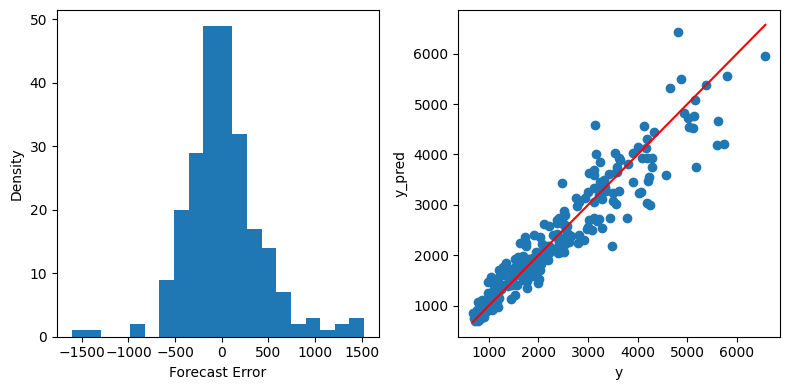

In [24]:
plot_model_performance(results)

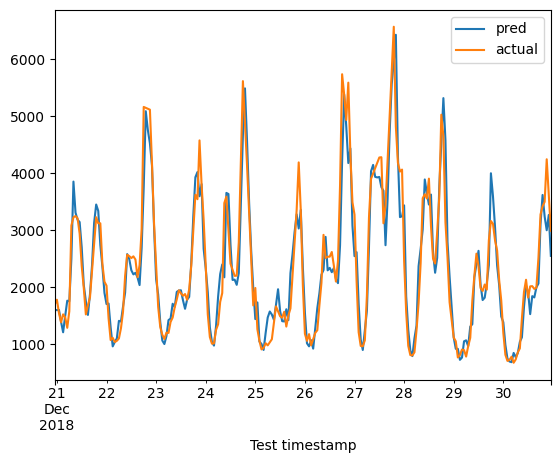

In [25]:
# Plot test predictions
results[['timestamp','pred', 'actual']].set_index('timestamp').plot()
plt.xlabel('Test timestamp')
plt.show()

In [26]:
def give_me_metrics(df):
    mae_test = mean_absolute_error(df.actual, df.pred)
    mse_test = mean_squared_error(df.actual, df.pred)
    rmse_test = mean_squared_error(df.actual, df.pred, squared=False)
    mape_test = mean_absolute_percentage_error(df.actual, df.pred)
    r2_test = r2_score(df.actual, df.pred)

    metric_df = pd.DataFrame({'MAE': [mae_test], 'MSE' : [mse_test], 'RMSE' : [rmse_test], 'MAPE': [mape_test], 'R2':[r2_test]})
    return metric_df

In [27]:
give_me_metrics(results)

,MAE,MSE,RMSE,MAPE,R2
0,292.914372,172360.432783,415.16314,0.127069,0.888849


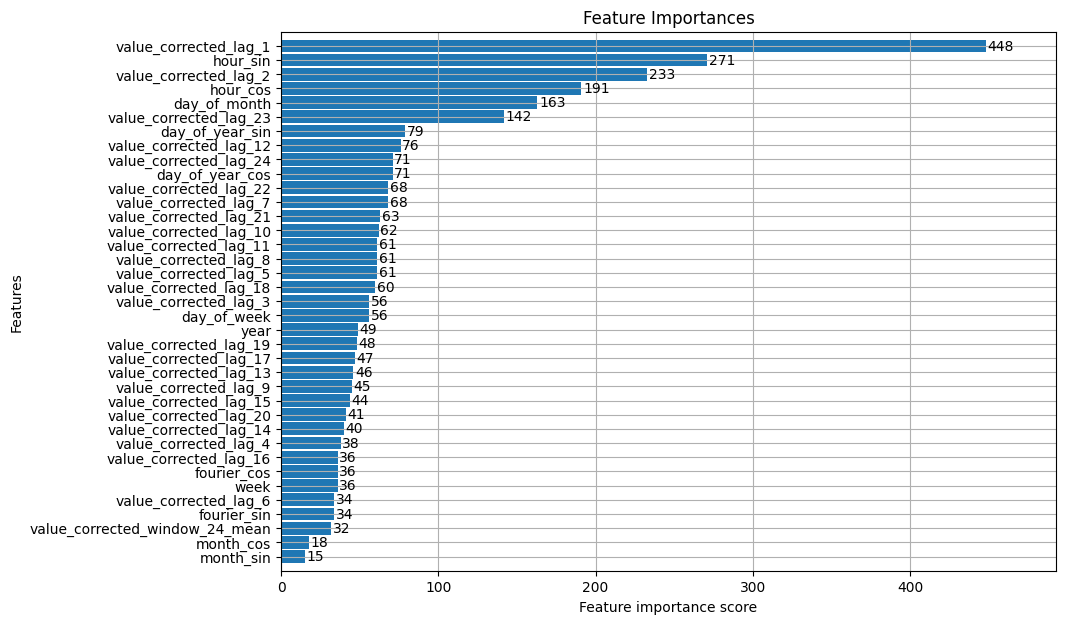

In [62]:
lgbm.plot_importance(model, figsize=(10,7), height=0.9, title="Feature Importances", xlabel="Feature importance score", ylabel="Features")
plt.show()

# Recursive Forecast

In [37]:
# Forecasting 24 hours ahead
forecast_point = X_test.index.max() + pd.offsets.Hour(1)
forecast_end = forecast_point + pd.offsets.Hour(23)

index = pd.date_range(
    start= forecast_point,
    end= forecast_end,
    freq='1H'
)

f_horizon = pd.DataFrame(columns=['value'], index= index)

start_point = forecast_point - pd.offsets.Hour(24)
input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]

input_data.loc[forecast_point] = np.NaN
input_data_df = prep_pipeline.transform(input_data)
rec_preds = model.predict(input_data_df)

f_horizon.loc[forecast_point] = rec_preds
input_data.loc[forecast_point] = rec_preds

In [38]:
input_data_df

,day_of_month,year,week,day_of_week,weekend,hour_sin,hour_cos,month_sin,month_cos,day_of_year_sin,...,value_corrected_lag_16,value_corrected_lag_17,value_corrected_lag_18,value_corrected_lag_19,value_corrected_lag_20,value_corrected_lag_21,value_corrected_lag_22,value_corrected_lag_23,value_corrected_lag_24,value_corrected_window_24_mean
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31 00:00:00+01:00,30,2018,52,6,1,-2.449294e-16,1.0,-2.449294e-16,1.0,-0.034328,...,930.0,860.0,736.0,678.0,785.0,730.0,710.0,818.0,1203.0,1932.1875


In [39]:
for i in range(23):
    
    # Re-slice the input data
    start_point = start_point + pd.offsets.Hour(1)
    forecast_point = forecast_point + pd.offsets.Hour(1)

    input_data = input_data[(input_data.index >= start_point)]
    input_data.loc[forecast_point] = np.nan

    # Obtain the prediction
    pred = model.predict(prep_pipeline.transform(input_data))

    # Add prediction to horizon.
    f_horizon.loc[forecast_point] = pred
    input_data.loc[forecast_point] = pred

f_horizon.index.name = "timestmap"

In [45]:
forecast_results = f_horizon.merge(out_of_sample_df, right_on="timestamp", left_index=True) \
                            .rename(columns={"value": "pred", "value_corrected": "actual"})

<Axes: xlabel='timestamp'>

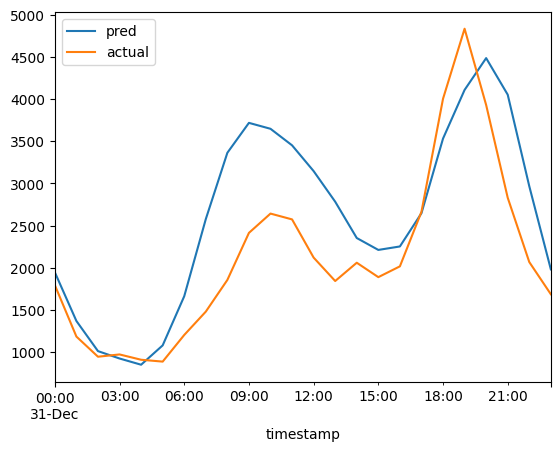

In [49]:
forecast_results.set_index("timestamp").plot()

In [50]:
# Metrics
give_me_metrics(forecast_results)

,MAE,MSE,RMSE,MAPE,R2
0,581.9282,538248.175864,733.653989,0.280171,0.459504
